Verify the imports
NOTE: Please do NOT edit this panel! 

In [7]:
print('* Verifying the packages')
# System packages 
import os
import pathlib 
import sys 
import warnings
warnings.filterwarnings('ignore') # Ignore all the warnings 

# Path hidpy
sys.path.append('%s/../' % os.getcwd())

# Internal packages 
from core import file_utils
from core import optical_flow
from core import video_processing
from core import plotting
from core import msd
from core import inference

print('\t* All required packages were successfully imported!')

* Verifying the packages
	* All required packages were successfully imported!


In [8]:
############ INPUTS PANEL, YOU CAN EDIT THIS PANEL ############ 
# Input video sequence (single sequence)   
video_sequence = '%s/../data/microscopes/h2b/u2os-h2bgfp-serum-3.avi' % os.getcwd() # parameters of this sequence: pixel_size=0.088, dt=0.200
#video_sequence = '%s/../data/microscopes/dna/3.avi' % os.getcwd()                    # parameters of this sequence: pixel_size=0.065, dt=0.200
nameOutput='u2os-h2bgfp-serum-3'

# Pixel threshold
pixel_threshold = 100

# Pixel size (should be in microns)
pixel_size = 0.088

# Time step (should be in seconds)
dt = 0.200 

# Output directory 
root_output_directory = '%s/../output-paper/' % os.getcwd()
############ INPUTS PANEL, YOU CAN EDIT THIS PANEL ############ 

In [9]:
################# PLEASE DON'T EDIT THIS PANEL #################
# Verify the input parameters, and return the path where the output data will be written  
output_directory = file_utils.veryify_input_options(
    video_sequence=video_sequence, output_directory=root_output_directory, 
    pixel_threshold=pixel_threshold, pixel_size=pixel_size, dt=dt)

# Load the frames from the video 
print('* Loading frames')
frames = video_processing.get_frames_list_from_video(
    video_path=video_sequence, verbose=True)
print('\t* Frames loaded!')
################# PLEASE DON'T EDIT THIS PANEL #################

NOTE: The output path [/ssd1/projects/hidpy/notebooks/../output-paper/] exists
* Loading frames
	* Video Details: 
  	* Name: /ssd1/projects/hidpy/notebooks/../data/microscopes/h2b/u2os-h2bgfp-serum-3.avi 
  	* Number Frames 150  	* FPS: 7.000000


100%|██████████████████████████████████████████████████| 150/150 [00:00<00:00, 243.03it/s]

	* Frames loaded!


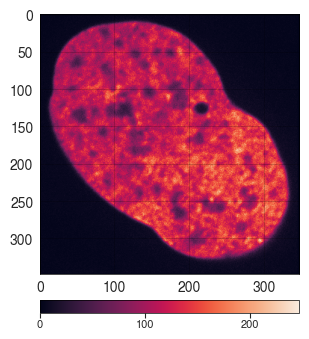

In [147]:
# Plot the frames 

import seaborn 
from matplotlib import ticker
from matplotlib import colors


from matplotlib import pyplot 
plotting.verify_plotting_packages()

font_size = 10
seaborn.set_style("whitegrid")
pyplot.rcParams['axes.grid'] = 'True'
pyplot.rcParams['grid.linewidth'] = 0.5
pyplot.rcParams['grid.color'] = 'black'
pyplot.rcParams['grid.alpha'] = 0.25
pyplot.rcParams['font.family'] = 'NimbusSanL'
pyplot.rcParams['font.monospace'] = 'Regular'
pyplot.rcParams['font.style'] = 'normal'
pyplot.rcParams['axes.labelweight'] = 'light'
pyplot.rcParams['axes.linewidth'] = 0.5
pyplot.rcParams['axes.labelsize'] = font_size
pyplot.rcParams['xtick.labelsize'] = font_size
pyplot.rcParams['ytick.labelsize'] = font_size
pyplot.rcParams['legend.fontsize'] = font_size
pyplot.rcParams['figure.titlesize'] = font_size
pyplot.rcParams['axes.titlesize'] = font_size
pyplot.rcParams['xtick.major.pad'] = '1'
pyplot.rcParams['ytick.major.pad'] = '1'
pyplot.rcParams['axes.edgecolor'] = '0'

cmap = colors.ListedColormap(['b','g','y','r'])
bounds=[0,1,2,3,4]
norm = colors.BoundaryNorm(bounds, cmap.N)


#plotting.plot_frame(frames[0], '', '')
fig, ax = pyplot.subplots()
im = pyplot.imshow(frames[0])
cax = ax.inset_axes([0.00, -0.15, 1.0, 0.05])
CB = pyplot.colorbar(im, ax=ax, cax=cax, orientation="horizontal")
CB.ax.tick_params(labelsize=8) 
tick_locator = ticker.MaxNLocator(nbins=3)
CB.locator = tick_locator

CB.update_ticks()

pyplot.savefig('/projects/hidpy/output2/frame.png', dpi=300, bbox_inches='tight')

In [14]:
################# PLEASE DON'T EDIT THIS PANEL #################



# Compute the optical flow
print('* Computing optical flow') 
u, v = optical_flow.compute_optical_flow_farneback(frames=frames)
print('\t* Optical flow computed!\n') 

# Interpolate the flow field
print('* Computing interpolations')
u, v = optical_flow.interpolate_flow_fields(u_arrays=u, v_arrays=v)
print('\t* Interpolations computed!\n')

# Compute the trajectories 
print('* Creating trajectories')
trajectories = optical_flow.compute_trajectories(
    frame=frames[0], fu_arrays=u, fv_arrays=v, pixel_threshold=pixel_threshold)
print('\t* Trajectories created!\n')

# Plot the trajectories 
print('* Plotting trajectories')
plotting.plot_trajectories_on_frame(
    frame=frames[0], trajectories=trajectories, 
    output_path='%s/trajectories' % output_directory)
print('\t* Trajectories rendered!\n')

################## PLEASE DON'T EDIT THIS PANEL #################

ValueError: Key axes.edgecolor: '10' does not look like a color arg

In [6]:
# Calculation of the MSD (mean square displacement)

# Construct trajectory map
print('* Converting the trajectories to maps')
xp, yp = msd.convert_trajectories_to_map(trajectories, (len(frames), frames[0].shape[0], frames[0].shape[1]))

# Convert displacement to microns
xp_um=xp*pixel_size
yp_um=yp*pixel_size

# extract nucleoli mask
print('* Extracting the nucleoli map')
mask_nucleoli = msd.extract_nucleoli_map(xp_um, yp_um)

# Compute the MSDs
print('* Computing the MSDs')
MSD = msd.calculate_msd_for_every_pixel(xp_um, yp_um, mask_nucleoli)

# Baysian fit on MSDs
print('* Fitting the MSDs models using Bayesian inference')

### THIS SHOULD BE SELECTED FROM THE CONFIG FILE 
models_selected = ['D','DA','V','DV','DAV'] 

# THE TIME STEP SHOULD BE SET IN THE CONFIG GILE 
dT = dt
Bayes = inference.apply_bayesian_inference(MSD, dT, models_selected)

* Converting the trajectories to maps
* Extracting the nucleoli map
* Computing the MSDs
* Fitting the MSDs models using Bayesian inference
Bayesian inference..
Using # cores:8


  0%|          | 8/53695 [00:00<1:12:12, 12.39it/s]<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<fro

  0%|          | 216/53695 [00:04<15:18, 58.22it/s]

  1%|          | 296/53695 [00:06<20:25, 43.56it/s]

  1%|          | 328/53695 [00:07<19:13, 46.25it/s]

  1%|          | 616/53695 [00:13<20:41, 42.76it/s]

  1%|          | 664/53695 [00:14<20:48, 42.49it/s]

  1%|▏         | 680/53695 [00:15<20:41, 42.69it/s]

  1%|▏         | 696/53695 [00:15<20:35, 42.90it/s]

  1%|▏         | 760/53695 [00:17<20:23, 43.27it/s]

  1%|▏         | 776/53695 [00:17<18:47, 46.92it/s]

  2%|▏         | 840/53695 [00:18<20:04, 43.86it/s]

  2%|▏         | 920/53695 [00:20<20:15, 43.44it/s]

  2%|▏         | 936/53695 [00:20<18:44, 46.92it/s]

  2%|▏         | 1096/53695 [00:24<18:12, 48.14it/s]

  3%|▎         | 1400/53695 [00:31<20:06, 43.36it/s]

  3%|▎         | 1496/53695 [00:33<20:49, 41.78it/s]

  3%|▎         | 1720/53695 [00:38<18:25, 47.01it/s]

  4%|▎         | 1896/53695 [00:42<19:26, 44.42it/s]

  4%|▍         | 2024/53695 [00:45<19:02, 45.22it/s]

  4%|▍         | 2056/53695 [00:46<19:52, 43.31it/s]

  5%|▍         | 2488/53695 [00:55<18:05, 47.17it/s]

  5%|▌         | 2728/53695 [01:01<18:42, 45.39it/s]

  5%|▌         | 2760/53695 [01:01<19:13, 44.17it/s]

  5%|▌         | 2920/53695 [01:05<18:03, 46.87it/s]

  6%|▌         | 3240/53695 [01:12<19:20, 43.47it/s]

  7%|▋         | 3496/53695 [01:17<19:36, 42.67it/s]

  7%|▋         | 3880/53695 [01:26<17:35, 47.20it/s]

  7%|▋         | 4008/53695 [01:28<17:18, 47.87it/s]

  8%|▊         | 4120/53695 [01:31<16:40, 49.57it/s]

  8%|▊         | 4184/53695 [01:32<16:50, 48.98it/s]

  8%|▊         | 4264/53695 [01:34<17:00, 48.46it/s]

  8%|▊         | 4408/53695 [01:37<17:14, 47.64it/s]

  9%|▊         | 4616/53695 [01:41<16:48, 48.64it/s]

  9%|▉         | 4760/53695 [01:44<17:12, 47.38it/s]

  9%|▉         | 4904/53695 [01:47<17:34, 46.27it/s]

  9%|▉         | 5048/53695 [01:51<17:12, 47.11it/s]

 10%|▉         | 5160/53695 [01:53<17:56, 45.09it/s]

 10%|▉         | 5176/53695 [01:53<17:52, 45.24it/s]

 10%|█         | 5416/53695 [01:59<16:46, 47.96it/s]

 10%|█         | 5432/53695 [01:59<16:29, 48.79it/s]

 11%|█         | 5656/53695 [02:04<17:02, 46.97it/s]

 11%|█         | 5784/53695 [02:07<17:19, 46.10it/s]

 11%|█         | 5912/53695 [02:10<18:54, 42.12it/s]

 11%|█         | 5944/53695 [02:10<17:14, 46.14it/s]

 12%|█▏        | 6184/53695 [02:16<18:01, 43.92it/s]

 12%|█▏        | 6328/53695 [02:19<18:01, 43.81it/s]

 12%|█▏        | 6584/53695 [02:24<19:22, 40.54it/s]

 13%|█▎        | 6712/53695 [02:27<17:26, 44.89it/s]

 13%|█▎        | 6904/53695 [02:32<17:30, 44.56it/s]

 13%|█▎        | 7176/53695 [02:38<16:31, 46.91it/s]

 14%|█▍        | 7400/53695 [02:43<17:25, 44.28it/s]

 14%|█▍        | 7768/53695 [02:51<17:24, 43.97it/s]

 15%|█▍        | 7816/53695 [02:52<16:39, 45.89it/s]

 15%|█▍        | 7992/53695 [02:56<16:35, 45.93it/s]

 15%|█▍        | 8040/53695 [02:57<16:53, 45.05it/s]

 15%|█▌        | 8104/53695 [02:59<16:37, 45.72it/s]

 15%|█▌        | 8152/53695 [03:00<15:36, 48.65it/s]

 16%|█▌        | 8424/53695 [03:05<16:37, 45.38it/s]

 16%|█▌        | 8520/53695 [03:07<15:47, 47.66it/s]

 16%|█▌        | 8600/53695 [03:09<17:41, 42.46it/s]

 17%|█▋        | 9176/53695 [03:22<16:09, 45.92it/s]

 17%|█▋        | 9256/53695 [03:23<16:24, 45.12it/s]

 18%|█▊        | 9448/53695 [03:28<15:41, 46.97it/s]

 18%|█▊        | 9640/53695 [03:32<14:31, 50.54it/s]

 18%|█▊        | 9704/53695 [03:33<15:45, 46.51it/s]

 18%|█▊        | 9816/53695 [03:36<16:12, 45.12it/s]

 19%|█▉        | 10168/53695 [03:44<15:12, 47.72it/s]

 19%|█▉        | 10200/53695 [03:44<16:11, 44.75it/s]

 19%|█▉        | 10280/53695 [03:46<15:35, 46.42it/s]

 20%|█▉        | 10536/53695 [03:52<16:03, 44.79it/s]

 20%|█▉        | 10552/53695 [03:52<15:37, 46.02it/s]

 20%|█▉        | 10568/53695 [03:52<15:54, 45.19it/s]

 20%|██        | 10856/53695 [03:58<14:38, 48.75it/s]

 20%|██        | 10872/53695 [03:59<14:40, 48.66it/s]

 20%|██        | 10968/53695 [04:01<15:36, 45.63it/s]

 21%|██        | 11208/53695 [04:06<16:00, 44.24it/s]

 21%|██        | 11240/53695 [04:07<16:09, 43.79it/s]

 21%|██        | 11368/53695 [04:10<15:39, 45.04it/s]

 21%|██▏       | 11512/53695 [04:13<14:50, 47.39it/s]

 22%|██▏       | 11656/53695 [04:16<15:53, 44.09it/s]

 22%|██▏       | 11816/53695 [04:20<15:42, 44.45it/s]

 22%|██▏       | 11976/53695 [04:23<14:32, 47.83it/s]

 23%|██▎       | 12216/53695 [04:28<14:13, 48.62it/s]

 23%|██▎       | 12488/53695 [04:34<16:29, 41.64it/s]

 24%|██▍       | 13096/53695 [04:48<14:16, 47.43it/s]

 26%|██▋       | 14184/53695 [05:12<16:00, 41.13it/s]

 27%|██▋       | 14344/53695 [05:15<14:36, 44.90it/s]

 27%|██▋       | 14536/53695 [05:20<14:45, 44.20it/s]

 27%|██▋       | 14664/53695 [05:23<14:33, 44.69it/s]

 28%|██▊       | 14872/53695 [05:28<14:26, 44.80it/s]

 28%|██▊       | 14968/53695 [05:30<14:25, 44.74it/s]

 28%|██▊       | 15016/53695 [05:31<15:10, 42.50it/s]

 28%|██▊       | 15096/53695 [05:33<13:59, 46.00it/s]

 29%|██▊       | 15320/53695 [05:37<13:45, 46.50it/s]

 29%|██▉       | 15656/53695 [05:45<15:28, 40.96it/s]

 30%|███       | 16328/53695 [06:00<14:21, 43.37it/s]

 31%|███       | 16456/53695 [06:03<14:33, 42.64it/s]

 31%|███       | 16568/53695 [06:05<13:36, 45.49it/s]

 31%|███       | 16648/53695 [06:07<13:42, 45.03it/s]

 31%|███       | 16744/53695 [06:09<13:33, 45.44it/s]

 31%|███       | 16776/53695 [06:10<13:38, 45.13it/s]

 31%|███▏      | 16904/53695 [06:13<15:15, 40.18it/s]

 32%|███▏      | 16968/53695 [06:15<14:14, 42.98it/s]

 32%|███▏      | 17304/53695 [06:22<12:20, 49.12it/s]

 32%|███▏      | 17368/53695 [06:23<13:15, 45.67it/s]

 33%|███▎      | 17784/53695 [06:33<13:42, 43.65it/s]

 34%|███▍      | 18136/53695 [06:40<12:11, 48.64it/s]

 34%|███▍      | 18184/53695 [06:41<11:44, 50.41it/s]

 34%|███▍      | 18200/53695 [06:42<12:07, 48.78it/s]

 34%|███▍      | 18280/53695 [06:43<12:08, 48.59it/s]

 34%|███▍      | 18312/53695 [06:44<12:10, 48.44it/s]

 35%|███▍      | 18552/53695 [06:49<12:38, 46.32it/s]

 35%|███▍      | 18680/53695 [06:52<12:20, 47.32it/s]

 38%|███▊      | 20440/53695 [07:30<12:16, 45.15it/s]

 39%|███▉      | 21192/53695 [07:46<11:35, 46.71it/s]

 40%|███▉      | 21400/53695 [07:51<11:59, 44.91it/s]

 40%|████      | 21720/53695 [07:57<11:28, 46.46it/s]

 41%|████      | 21960/53695 [08:02<11:03, 47.84it/s]

 41%|████▏     | 22264/53695 [08:09<11:16, 46.47it/s]

 42%|████▏     | 22360/53695 [08:11<11:26, 45.66it/s]

 42%|████▏     | 22488/53695 [08:14<11:20, 45.88it/s]

 43%|████▎     | 22840/53695 [08:21<10:37, 48.38it/s]

 43%|████▎     | 22920/53695 [08:23<10:33, 48.59it/s]

 43%|████▎     | 23048/53695 [08:26<10:52, 46.94it/s]

 43%|████▎     | 23272/53695 [08:30<11:32, 43.92it/s]

 44%|████▎     | 23432/53695 [08:34<11:02, 45.65it/s]

 44%|████▍     | 23496/53695 [08:35<10:33, 47.65it/s]

 44%|████▍     | 23544/53695 [08:36<10:27, 48.07it/s]

 44%|████▍     | 23784/53695 [08:41<10:28, 47.59it/s]

 45%|████▍     | 24008/53695 [08:46<09:51, 50.18it/s]

 45%|████▍     | 24120/53695 [08:48<10:45, 45.78it/s]

 46%|████▌     | 24488/53695 [08:56<10:40, 45.62it/s]

 47%|████▋     | 25080/53695 [09:09<10:29, 45.48it/s]

 50%|████▉     | 26648/53695 [09:44<10:45, 41.87it/s]

 51%|█████     | 27352/53695 [10:00<09:32, 46.00it/s]

 52%|█████▏    | 27848/53695 [10:12<09:08, 47.11it/s]

 54%|█████▎    | 28760/53695 [10:31<08:57, 46.37it/s]

 56%|█████▌    | 30024/53695 [11:00<08:47, 44.86it/s]

 57%|█████▋    | 30552/53695 [11:11<08:42, 44.27it/s]

 58%|█████▊    | 31368/53695 [11:30<08:00, 46.46it/s]

 59%|█████▊    | 31432/53695 [11:31<07:54, 46.93it/s]

 59%|█████▉    | 31624/53695 [11:35<08:01, 45.84it/s]

 59%|█████▉    | 31688/53695 [11:37<08:00, 45.77it/s]

 60%|█████▉    | 32168/53695 [11:47<08:04, 44.45it/s]

 60%|██████    | 32408/53695 [11:52<07:35, 46.73it/s]

 61%|██████    | 32648/53695 [11:58<07:40, 45.67it/s]

 62%|██████▏   | 33384/53695 [12:15<08:23, 40.37it/s]

 64%|██████▍   | 34424/53695 [12:38<06:42, 47.88it/s]

 65%|██████▍   | 34664/53695 [12:43<06:43, 47.11it/s]

 65%|██████▌   | 35144/53695 [12:53<07:00, 44.12it/s]

 66%|██████▌   | 35432/53695 [12:59<06:14, 48.73it/s]

 67%|██████▋   | 35928/53695 [13:11<06:29, 45.56it/s]

 72%|███████▏  | 38664/53695 [14:10<05:14, 47.72it/s]

 73%|███████▎  | 39400/53695 [14:27<05:18, 44.94it/s]

 73%|███████▎  | 39432/53695 [14:28<05:25, 43.76it/s]

 74%|███████▍  | 39896/53695 [14:38<05:01, 45.80it/s]

 75%|███████▍  | 40232/53695 [14:45<04:40, 48.01it/s]

 77%|███████▋  | 41288/53695 [15:08<04:34, 45.13it/s]

 78%|███████▊  | 41720/53695 [15:17<04:12, 47.35it/s]

 79%|███████▊  | 42232/53695 [15:28<04:12, 45.43it/s]

 79%|███████▉  | 42312/53695 [15:30<04:11, 45.19it/s]

 79%|███████▉  | 42680/53695 [15:38<03:50, 47.81it/s]

 80%|███████▉  | 42952/53695 [15:44<03:54, 45.85it/s]

 82%|████████▏ | 43896/53695 [16:04<03:23, 48.24it/s]

 83%|████████▎ | 44408/53695 [16:15<03:18, 46.75it/s]

 83%|████████▎ | 44456/53695 [16:17<03:34, 43.13it/s]

 83%|████████▎ | 44808/53695 [16:24<03:18, 44.86it/s]

 88%|████████▊ | 47496/53695 [17:21<02:08, 48.29it/s]

 89%|████████▉ | 47864/53695 [17:30<02:07, 45.74it/s]

 92%|█████████▏| 49176/53695 [17:58<01:31, 49.40it/s]

 92%|█████████▏| 49608/53695 [18:07<01:25, 48.01it/s]

 93%|█████████▎| 49992/53695 [18:15<01:23, 44.31it/s]

 94%|█████████▎| 50248/53695 [18:21<01:14, 46.28it/s]

 94%|█████████▍| 50392/53695 [18:24<01:11, 46.12it/s]

 94%|█████████▍| 50536/53695 [18:27<01:07, 46.72it/s]

 95%|█████████▍| 50792/53695 [18:33<01:03, 45.45it/s]

 95%|█████████▍| 50936/53695 [18:36<01:01, 45.16it/s]

 96%|█████████▌| 51432/53695 [18:47<00:51, 44.14it/s]

 96%|█████████▌| 51624/53695 [18:51<00:45, 45.73it/s]

 96%|█████████▋| 51768/53695 [18:54<00:40, 47.09it/s]

 97%|█████████▋| 51864/53695 [18:56<00:39, 45.95it/s]

 97%|█████████▋| 52184/53695 [19:03<00:34, 44.43it/s]

 97%|█████████▋| 52280/53695 [19:05<00:30, 46.67it/s]

 99%|█████████▉| 53176/53695 [19:25<00:11, 43.73it/s]

 99%|█████████▉| 53384/53695 [19:29<00:06, 46.36it/s]

 99%|█████████▉| 53400/53695 [19:30<00:06, 45.43it/s]

100%|█████████▉| 53464/53695 [19:31<00:05, 43.25it/s]

100%|█████████▉| 53672/53695 [19:35<00:00, 47.32it/s]

 26%|██▌       | 13805/53695 [00:16<00:48, 817.41it/s]

In [1]:
from pylab import *
from matplotlib import colors

matrix1=np.zeros((frames[0].shape[0],frames[0].shape[1]))
matrix1[np.where(mask_nucleoli==1)]=100

bounds = [0.5, 1.5, 2.5, 3.5, 4.5]

fig,ax=plt.subplots(2,3,figsize=[12,10])
ax[0,2].axis('off')

img0=ax[0,0].imshow(frames[0],origin='lower',cmap='gray')
ax[0,0].set_title('Raw image')

cmap = colors.ListedColormap(['w','g','b','purple','r','greenyellow'])
img1=ax[0,1].imshow(Bayes['model'], interpolation='nearest',cmap=cmap,origin='lower')
ax[0,1].contour(matrix1, colors='k', origin='lower')

cbar=fig.colorbar(img1,ax=ax[0,1],spacing='proportional',orientation='horizontal',boundaries=[-0.5] + bounds + [5.5])
labels = np.arange(0, 6, 1)
loc = labels
cbar.set_ticks(loc)
cbar.set_ticklabels([' ','D','DA','V','DV','DAV'])
ax[0,1].set_title('Model Selection')

matD=[]
matD=Bayes['D']
matD[np.where(Bayes['model']==0)]=np.nan
matD[np.where(Bayes['D']<1e-10)]=np.nan

# #figure(2)
img2=ax[1,0].imshow(matD, interpolation='nearest',cmap='viridis',origin='lower')
ax[1,0].contour(matrix1, colors='k', origin='lower')
cbarD=fig.colorbar(img2,ax=ax[1,0],spacing='proportional',orientation='horizontal')
ax[1,0].set_title(r'Diffusion constant [$\mu$m$^2$/s]')


matA=[]
matA=Bayes['A']
matA[np.where(Bayes['model']==0)]=np.nan
matA[np.where(Bayes['A']<1e-10)]=np.nan

# #figure(3)
img3=ax[1,1].imshow(matA, interpolation='nearest',cmap='viridis',origin='lower')
ax[1,1].contour(matrix1, colors='k', origin='lower')
fig.colorbar(img3,ax=ax[1,1],spacing='proportional',orientation='horizontal')
ax[1,1].set_title('Anomalous exponent')

matV=[]
matV=Bayes['V']
matV[np.where(Bayes['model']==0)]=np.nan
matV[np.where(Bayes['V']==0)]=np.nan

# #figure(4)
img4=ax[1,2].imshow(matV, interpolation='nearest',cmap='viridis',origin='lower')
ax[1,2].contour(matrix1, colors='k', origin='lower')
fig.colorbar(img4,ax=ax[1,2],spacing='proportional',orientation='horizontal')
ax[1,2].set_title(r'Drift velocity [$\mu$m/s]')



NameError: name 'frames' is not defined

In [25]:
# Save pickle file per cell

import pickle

output_b = output_directory +"/" + str(pixel_threshold)+ "_" + "ex"
os.mkdir(output_b)

with open(output_b+'/Results_Bayes_'+nameOutput+'_'+str(pixel_threshold) +'.pickle', 'wb') as f:
#with open('%s/Results_Bayes_04102022_Cell01.pickle' % output_b, 'wb') as f:
    pickle.dump(Bayes, f)

FileExistsError: [Errno 17] File exists: '/ssd1/projects/hidpy/notebooks/../output-paper//u2os-h2bgfp-serum-3/100_ex'